In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
from torch_geometric.utils import from_networkx
from ipaddress import IPv4Address
import random
import logging
from torch_geometric.loader import DataLoader
import pickle

# Train Graph

### Load Dataset

In [2]:
filename = './Data/dataset.pt'


dataset = torch.load(filename, weights_only=False)


In [26]:
import torch
from torch_geometric.datasets import TUDataset
from pprint import pprint


print(len(dataset))
data = dataset[10]  # Get the first graph object.

print()
print(data)
print('=============================================================')



# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

11757

Data(edge_index=[2, 22], feature=[6, 110], num_nodes=6, x=[6, 48], y=1)
Number of nodes: 6
Number of edges: 22
Average node degree: 3.67
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [27]:
import random

random.shuffle(dataset)

# Split the dataset into training and test sets
split_ratio = 0.7
split_index = int(len(dataset) * split_ratio)
train_dataset = dataset[:split_index]
test_dataset = dataset[split_index:]




print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
    

Number of training graphs: 8229
Number of test graphs: 3528


In [28]:
ntest = len(test_dataset)
testcount = 0
testlow = 0
testhigh = 0
for t in test_dataset:
    if t.y.item() == 0:
        testcount+=1
    if t.y.item() == 1:
        testlow+=1
    if t.y.item() == 2:
        testhigh+=1

ntrain = len(train_dataset)
traincount = 0
trainlow = 0
trainhigh = 0
for t in train_dataset:
    if t.y.item() == 0:
        traincount+=1
    if t.y.item() == 1:
        trainlow+=1
    if t.y.item() == 2:
        trainhigh+=1

print('--------------Train--------------')
print(f'\033[1mPercent of low privilege compromised graphs: \033[0m{trainlow/ntrain}')
print(f'\033[1mPercent of not compromised graphs: \033[0m{traincount/ntrain}')



print('--------------Test--------------')
print(f'\033[1mPercent of low privilege compromised graphs: \033[0m{testlow/ntest}')
print(f'\033[1mPercent of not compromised graphs: \033[0m{testcount/ntest}')

--------------Train--------------
Percent of low privilege compromised graphs: 0.43601895734597157
Percent of not compromised graphs: 0.5639810426540285
--------------Test--------------
Percent of low privilege compromised graphs: 0.4305555555555556
Percent of not compromised graphs: 0.5694444444444444


### GCN

In [29]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

#Specify device manually
use_gpu = True # Set to False to use CPU
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")


# DataLoader (ensure `train_dataset` and `test_dataset` are loaded correctly)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_dim = len(train_dataset[0].x[0])

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, input_dim=input_dim, hidden_channels=32, invert_output=False):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(input_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]


        x = self.lin(x)
        x = self.sigmoid(x)

        return x

model = GCN(hidden_channels=32)
print(model)

Using device: cuda
GCN(
  (conv1): GCNConv(48, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)


In [30]:
from sklearn.metrics import precision_score, recall_score


# Initialize the model, optimizer, and loss function
model = GCN(hidden_channels=64).to(device)  # Move model to GPU
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

losses = []  # Training losses
test_losses = []  # Test losses
accs = []  # Test accuracies
precisions = []  # Test precisions
recalls = []  # Test recalls
train_accs = []  # Training accuracies


# Define the training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)  # Move batch data to GPU
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        total_loss += loss.item()  # Accumulate loss for this epoch.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    
    # Print the accuracy for the current batch
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct = int((pred == data.y).sum())  # Check against ground-truth labels.
    acc = correct / len(data.y)  # Derive ratio of correct predictions.
    train_accs.append(acc)  # Append accuracy to the list.
    avg_loss = total_loss / len(train_loader)  # Calculate average loss for this epoch.
    losses.append(avg_loss)  # Append the average loss to the list.

# Define the testing loop
def test(loader):
    model.eval()
    correct = 0
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation during evaluation.
        for data in loader:  # Iterate in batches over the training/test dataset.
            data = data.to(device)  # Move batch data to GPU
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)  # Compute the loss for the batch.
            total_loss += loss.item()  # Accumulate test loss.
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.

            # Collect predictions and true labels for precision and recall
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    avg_loss = total_loss / len(loader)  # Calculate average test loss.
    test_losses.append(avg_loss)  # Append the average test loss to the list.
    acc = correct / len(loader.dataset)  # Derive ratio of correct predictions.
    accs.append(acc)  # Append accuracy to the list.

    # Compute precision and recall
    precision = precision_score(all_labels, all_preds, average='macro',zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    precisions.append(precision)
    recalls.append(recall)

    return acc, avg_loss, precision, recall

# Training and testing loop
for epoch in range(1, 101):
    train()
    test_acc, test_loss, precision, recall = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Loss: {losses[-1]:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accs[-1]:.4f}, Test Acc: {test_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')


Epoch: 001, Train Loss: 0.6554, Test Loss: 0.5218, Train Acc: 0.8649, Test Acc: 0.8296, Precision: 0.8317, Recall: 0.8194
Epoch: 002, Train Loss: 0.5187, Test Loss: 0.4258, Train Acc: 0.7838, Test Acc: 0.8977, Precision: 0.8979, Recall: 0.8929
Epoch: 003, Train Loss: 0.4561, Test Loss: 0.4010, Train Acc: 0.8919, Test Acc: 0.9158, Precision: 0.9167, Recall: 0.9113
Epoch: 004, Train Loss: 0.4268, Test Loss: 0.3849, Train Acc: 0.8378, Test Acc: 0.9323, Precision: 0.9332, Recall: 0.9285
Epoch: 005, Train Loss: 0.4123, Test Loss: 0.3759, Train Acc: 0.9730, Test Acc: 0.9425, Precision: 0.9428, Recall: 0.9397
Epoch: 006, Train Loss: 0.3981, Test Loss: 0.3695, Train Acc: 0.9189, Test Acc: 0.9484, Precision: 0.9501, Recall: 0.9448
Epoch: 007, Train Loss: 0.3890, Test Loss: 0.3634, Train Acc: 0.9189, Test Acc: 0.9518, Precision: 0.9546, Recall: 0.9476
Epoch: 008, Train Loss: 0.3812, Test Loss: 0.3605, Train Acc: 0.9459, Test Acc: 0.9541, Precision: 0.9567, Recall: 0.9500
Epoch: 009, Train Loss: 

## Graphs

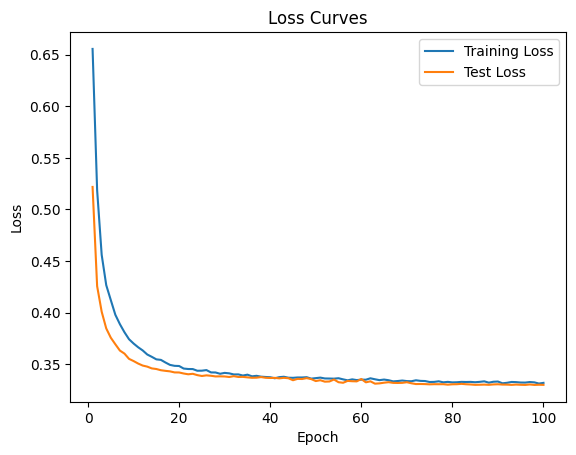

In [31]:
# Plot the loss curve
plt.plot(range(1, 101), losses, label='Training Loss')
plt.plot(range(1,101), test_losses, label='Test Loss')

plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.show()


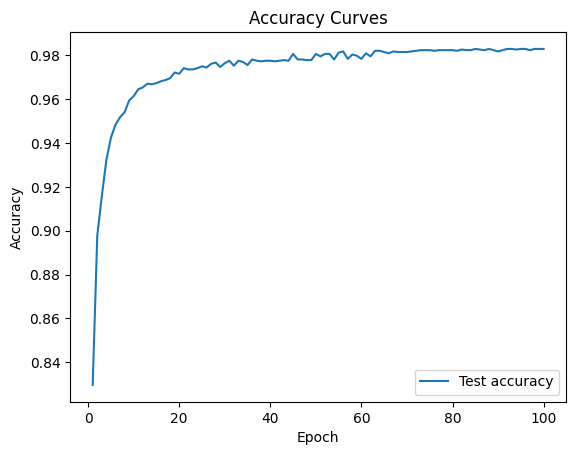

In [32]:
plt.plot(range(1, 101), accs, label='Test accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

plt.show()


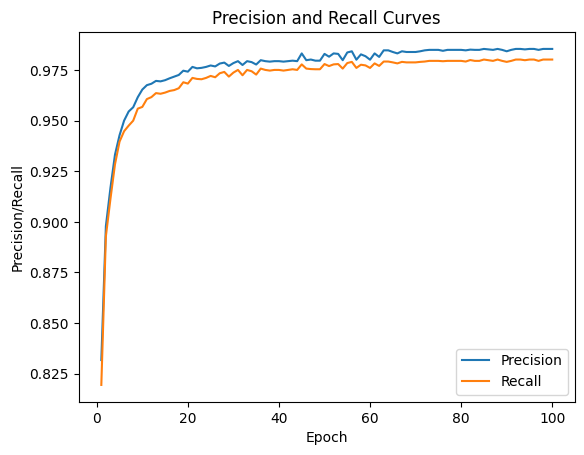

In [33]:
plt.plot(range(1, 101), precisions, label='Precision')
plt.plot(range(1, 101), recalls, label='Recall')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall Curves')
plt.show()

## Python to Matlab

In [38]:
dataset = torch.load('Data/dataset.pt', weights_only=False) 

In [36]:
import torch
import numpy as np
from scipy.io import savemat
from torch_geometric.utils import to_dense_adj



# Prepare plain Python lists for each attribute
edge_indices = []
features = []
labels = []

# Iterate through each Data object in the dataset
for data in dataset:
    # Convert to NumPy arrays if needed
    edge_index = data.edge_index.numpy() if isinstance(data.edge_index, torch.Tensor) else data.edge_index
    feature = data.x.numpy() if isinstance(data.x, torch.Tensor) else data.x
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
    adj_matrix = to_dense_adj(edge_index_tensor)[0].numpy()
    edge_index = adj_matrix
    label = data.y.numpy() if isinstance(data.y, torch.Tensor) else data.y

    num_nodes = feature.shape[0]

    edge_indices.append(edge_index)
    features.append(feature)
    labels.append(label)

# Manually create object arrays to avoid broadcasting issues
edge_indices_obj = np.empty(len(edge_indices), dtype=object)
features_obj = np.empty(len(features), dtype=object)
labels_obj = np.empty(len(labels), dtype=object)

for i in range(len(edge_indices)):
    edge_indices_obj[i] = edge_indices[i]
    features_obj[i] = features[i]
    labels_obj[i] = labels[i]

# Build the dictionary for saving to .mat
data_dict = {
    'edge_indices': edge_indices_obj,  # Now an object array (MATLAB cell array)
    'features': features_obj,          # Object array of feature matrices
    'labels': labels_obj               # Object array of labels
}

# Save to .mat file
savemat('converted_dataset.mat', data_dict)
print("Conversion to .mat complete!")


Conversion to .mat complete!
